# Caderno 6 - Calcula métricas considerando os resultados de pesquisa em um BM25 com expansão de documentos com doc2query

In [1]:
# Se True, refaz a indexação. Se False, tenta recuperar o
# índice do arquivo indice_js_enunciado_e_excerto.pickle.
# É necessário que esse arquivo exista.
REINDEXAR_ENUNCIADO_EXCERTO_DOC2QUEY = False

PASTA_DADOS = './dados/'
PASTA_RESULTADO_CADERNO = f'{PASTA_DADOS}outputs/6_metricas_bm25_com_doc2query/'
NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY = f'{PASTA_RESULTADO_CADERNO}indice_js_enunciado_e_excerto_e_doc2query.pickle'

## 1. Carrega base de dados

Carrega a lista de documentos para indexar, as queries para testar e o qrels.

In [2]:
import pandas as pd

# A pasta dos JURIS aqui não é a pasta original, e sim o resultado do caderno 1 (os documentos já estão filtrados)
PASTA_JURIS_TCU = f'{PASTA_DADOS}outputs/1_tratamento_juris_tcu/'

# Carrega os arquivos 
def carrega_juris_tcu():
    doc1 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_1.csv', sep='|')
    doc2 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_2.csv', sep='|')
    doc3 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_3.csv', sep='|')
    doc4 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_4.csv', sep='|')
    doc = pd.concat([doc1, doc2, doc3, doc4], ignore_index=True)
    query = pd.read_csv(f'{PASTA_JURIS_TCU}query_tratado.csv', sep='|')
    qrel = pd.read_csv(f'{PASTA_JURIS_TCU}qrel_tratado.csv', sep='|')

    return doc, query, qrel

docs, queries, qrels = carrega_juris_tcu()

Carrega a expansão das queries gerada no caderno anterior:

In [3]:
import pickle

PASTA_CADERNO_DOC2QUERY = f'{PASTA_DADOS}outputs/5_doc2query/'
NOME_ARQUIVO_DOC2QUERY = f'{PASTA_CADERNO_DOC2QUERY}doc2query.pickle'

# Fazemos o caminho inverso aqui:
with open(NOME_ARQUIVO_DOC2QUERY, 'rb') as f:
    queries_por_doc = pickle.load(f)

Insere a informação do doc2query no dataframe de documentos. Se o doc2query tiver gerado queries idênticas, desconsidera as duplicadas:

In [4]:
docs['DOC2QUERY'] = docs['KEY'].map(lambda key: " ".join(set(queries_por_doc[key])) )

## 2. Instancia um BM25 e indexa os campos ENUNCIADO e EXCERTO e as queries expandidas

In [5]:
from bm25 import IndiceInvertido, BM25, tokenizador_pt_remove_html

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [6]:
import os

# Vamos criar um índice invertido e indexar o enunciado, excerto e as queries geradas com o doc2query
iidx = IndiceInvertido(tokenizador_pt_remove_html)

if REINDEXAR_ENUNCIADO_EXCERTO_DOC2QUEY or not os.path.exists(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY):
    # Se for indexar a primeira vez:
    # Demora cerca de XX minutos para indexar
    iidx.adiciona_dataframe(docs, lambda row: (row['KEY'], row['ENUNCIADO'] + ' ' + row['EXCERTO'] + ' ' + row['DOC2QUERY']))
    iidx.to_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY)
else:
    # Se quiser recuperar de um arquivo:
    iidx.from_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY)

In [7]:
print(iidx.get_tamanho_medio_docs())

496.6854471798068


In [8]:
# Agora instancia um BM25
buscador = BM25(iidx, k1=0.82, b=0.68, bias_idf=1)

## 3. Faz as pesquisas e salva os resultados

In [9]:
col_resultado_query_key=[]
col_resultado_doc_key=[]
col_resultado_rank=[]

for i, row in queries.iterrows():
    query_key = row.KEY
    query_text = row.TEXT
    resultados = buscador.pesquisar(query_text)

    primeiros_50_docs = [tupla_key_score[0] for tupla_key_score in resultados[:50]]
    queries_keys = [query_key] * len(primeiros_50_docs)
    ranking = list(range(1, len(primeiros_50_docs)+1))

    col_resultado_query_key.extend(queries_keys)
    col_resultado_doc_key.extend(primeiros_50_docs)
    col_resultado_rank.extend(ranking)

df_resultados = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key,
    "DOC_KEY": col_resultado_doc_key,
    "RANK": col_resultado_rank,
})

In [10]:
from metricas import metricas

df_metricas = metricas(df_resultados, qrels, aproximacao_trec_eval=True)

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.384000,0.328000,0.249000,0.137600,0.155196,0.268060,0.409551,0.562088,0.631667,0.640714,0.645532,0.646485,0.397223,0.375083,0.438316,0.513416
std,14.57738,0.282381,0.190638,0.121424,0.050892,0.115963,0.166290,0.222225,0.241502,0.386159,0.372520,0.364484,0.362821,0.287662,0.228337,0.232349,0.215974
min,1.00000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.069683
25%,13.25000,0.200000,0.200000,0.150000,0.105000,0.071429,0.133333,0.235577,0.395604,0.333333,0.333333,0.333333,0.333333,0.170093,0.186419,0.229497,0.322349
50%,25.50000,0.400000,0.300000,0.250000,0.140000,0.142857,0.250000,0.400000,0.545455,0.500000,0.500000,0.500000,0.500000,0.359445,0.381714,0.431799,0.559164
75%,37.75000,0.600000,0.500000,0.300000,0.180000,0.230769,0.384615,0.491667,0.778571,1.000000,1.000000,1.000000,1.000000,0.617937,0.570334,0.641464,0.704286
max,50.00000,1.000000,0.700000,0.500000,0.220000,0.500000,0.600000,0.818182,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.846550,0.844624,0.844624


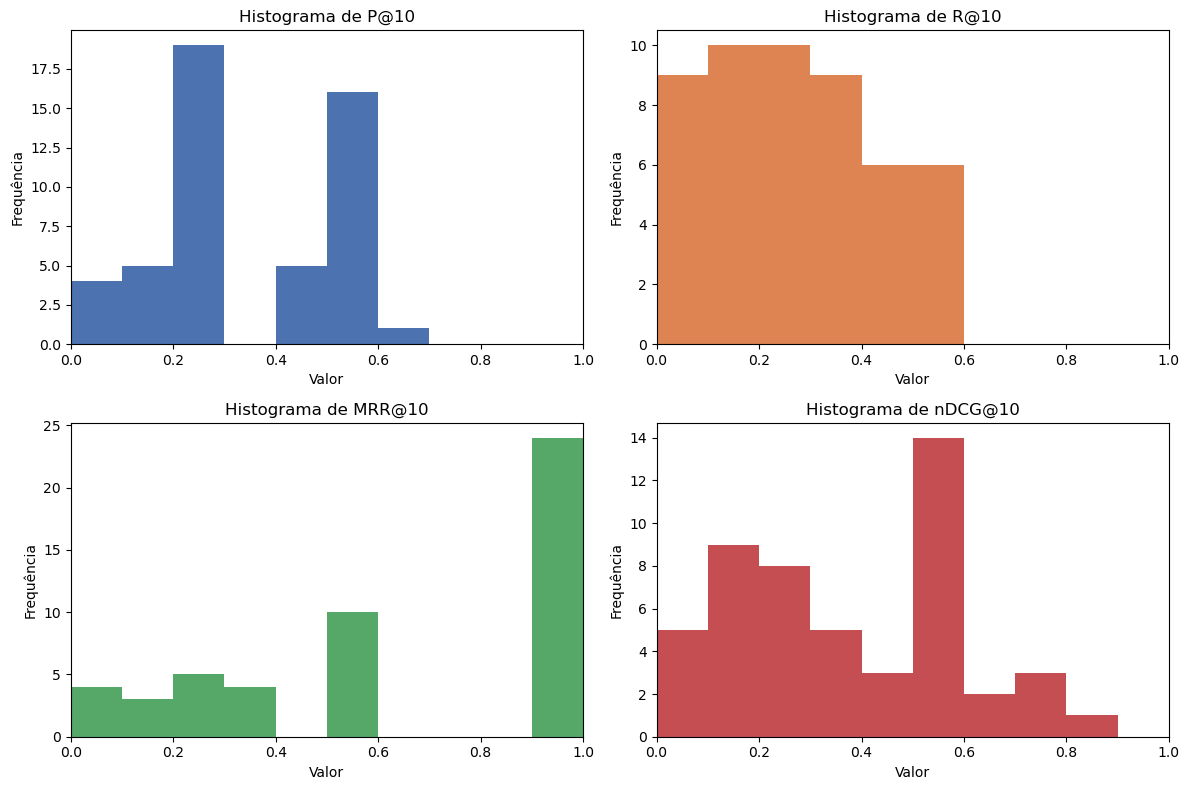

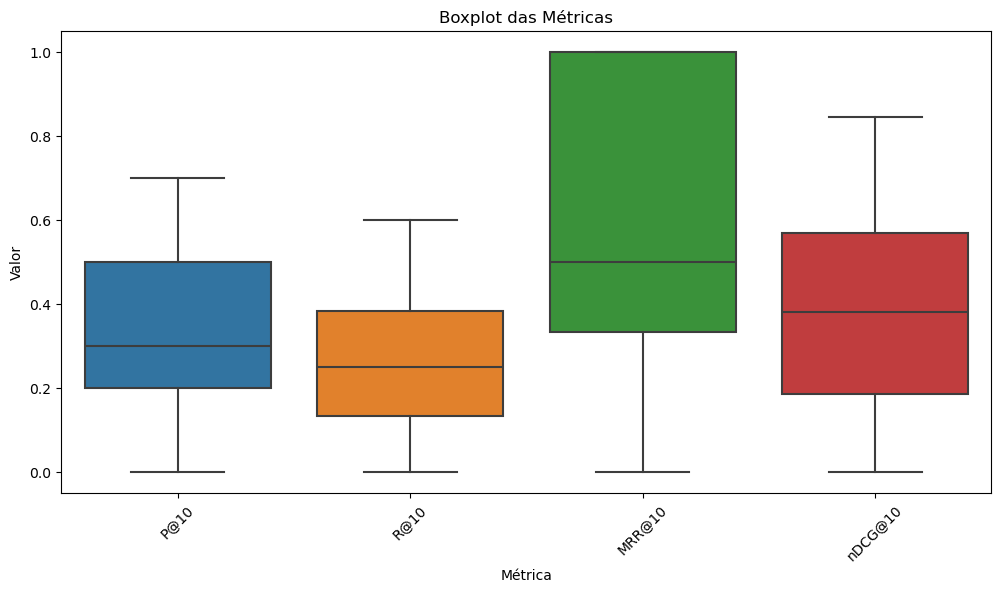

In [11]:
from metricas import histograma_metricas, boxplot_metricas

# Resultados para o primeiro grupo de queries:
display(df_metricas[0:50].describe())
histograma_metricas(df_metricas[0:50])
boxplot_metricas(df_metricas[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.544000,0.396000,0.268000,0.144000,0.228134,0.333435,0.448518,0.599726,0.899000,0.903444,0.903444,0.903444,0.621383,0.544876,0.580417,0.647425
std,14.57738,0.274167,0.205992,0.130447,0.049816,0.120330,0.188819,0.234727,0.224666,0.265055,0.250167,0.250167,0.250167,0.234069,0.191443,0.196683,0.176905
min,51.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.071429,0.076923,0.083333,0.000000,0.111111,0.111111,0.111111,0.000000,0.051685,0.127326,0.127326
25%,63.25000,0.400000,0.200000,0.150000,0.105000,0.145604,0.224359,0.255682,0.461538,1.000000,1.000000,1.000000,1.000000,0.508740,0.426671,0.465505,0.582096
50%,75.50000,0.600000,0.400000,0.250000,0.160000,0.230769,0.320513,0.422619,0.607692,1.000000,1.000000,1.000000,1.000000,0.656886,0.586693,0.601616,0.652317
75%,87.75000,0.800000,0.500000,0.350000,0.180000,0.307692,0.425595,0.583333,0.764423,1.000000,1.000000,1.000000,1.000000,0.755317,0.682128,0.697495,0.762523
max,100.00000,1.000000,0.800000,0.500000,0.200000,0.500000,0.800000,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.860382,0.931333,0.963408


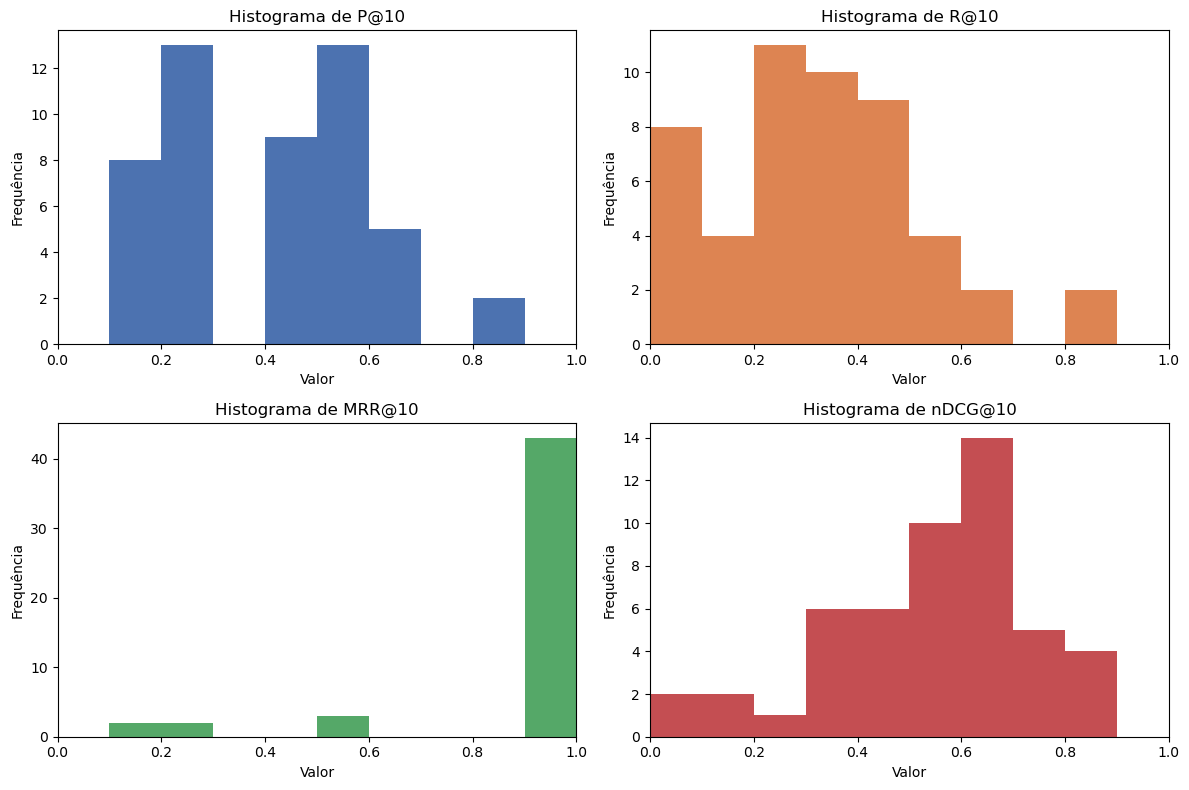

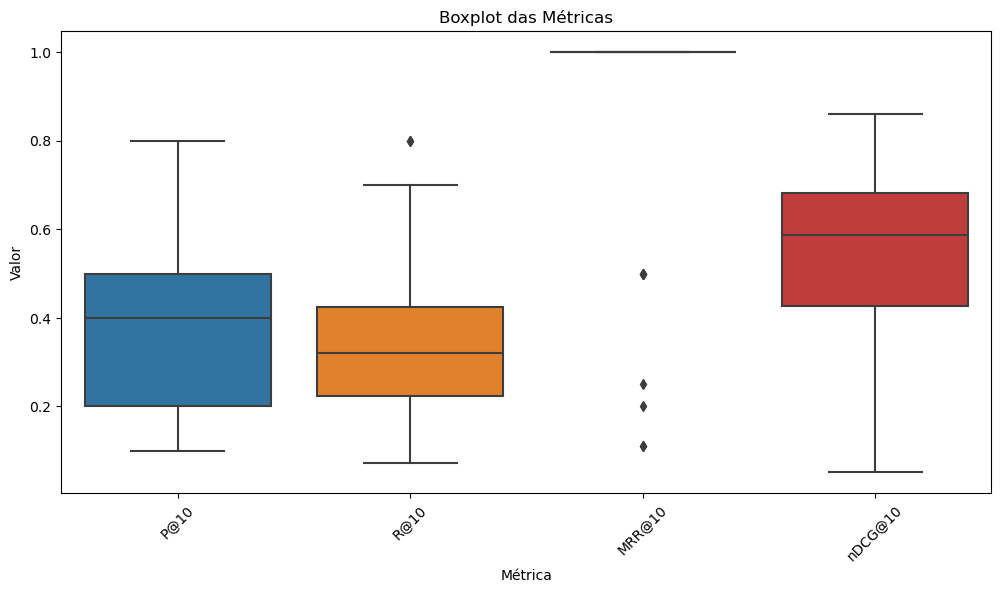

In [12]:
# Resultados para o segundo grupo de queries:
display(df_metricas[50:100].describe())
histograma_metricas(df_metricas[50:100])
boxplot_metricas(df_metricas[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.532000,0.400000,0.269000,0.139200,0.239059,0.355019,0.475914,0.612787,0.95400,0.956222,0.956222,0.956222,0.627193,0.551942,0.600869,0.656439
std,14.57738,0.247798,0.196915,0.125312,0.052366,0.119143,0.173357,0.222016,0.229170,0.19082,0.179813,0.179813,0.179813,0.204666,0.176814,0.180329,0.163838
min,101.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.066667,0.071429,0.100000,0.00000,0.111111,0.111111,0.111111,0.000000,0.070969,0.273531,0.273531
25%,113.25000,0.400000,0.225000,0.200000,0.120000,0.166667,0.230769,0.363636,0.538462,1.00000,1.000000,1.000000,1.000000,0.507790,0.462463,0.466792,0.523164
50%,125.50000,0.600000,0.400000,0.250000,0.140000,0.240385,0.333333,0.480769,0.615385,1.00000,1.000000,1.000000,1.000000,0.607863,0.571441,0.618352,0.686982
75%,137.75000,0.750000,0.500000,0.350000,0.180000,0.325000,0.459790,0.595833,0.750000,1.00000,1.000000,1.000000,1.000000,0.777695,0.692711,0.739474,0.783921
max,150.00000,1.000000,0.800000,0.500000,0.220000,0.500000,0.727273,0.909091,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.884592,0.949787,0.949787


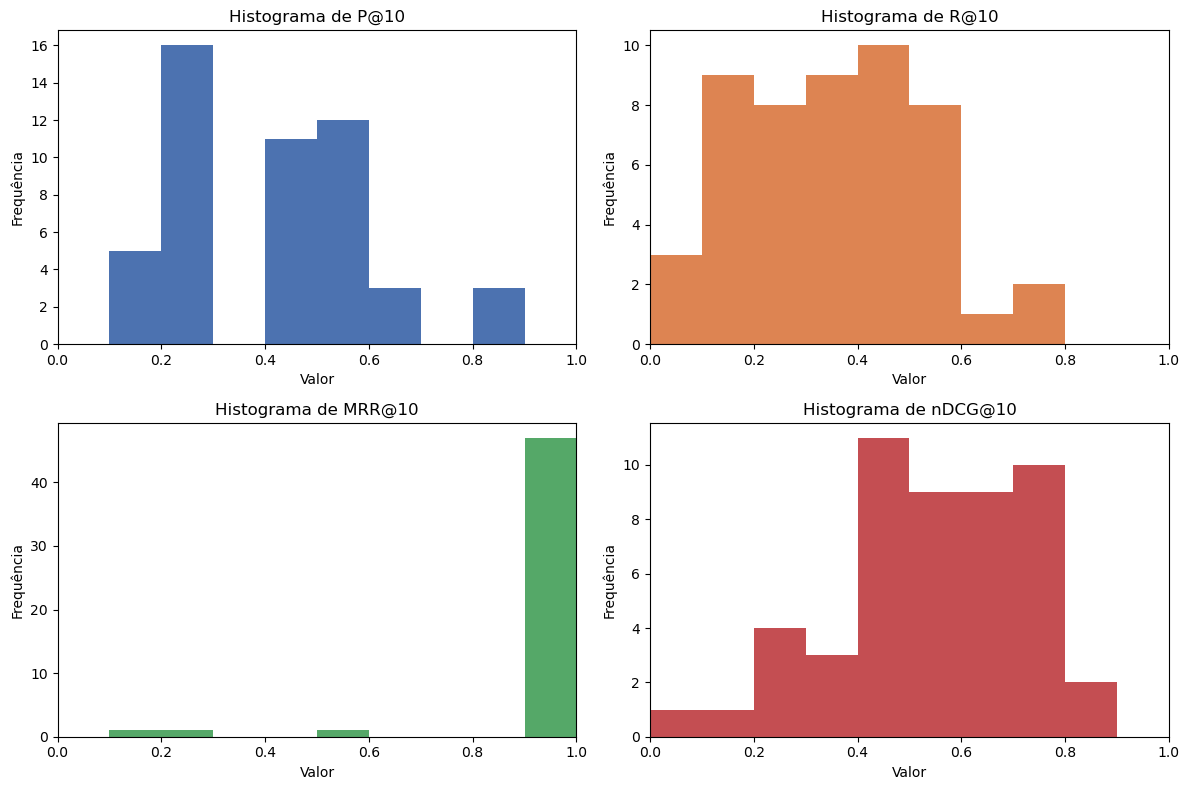

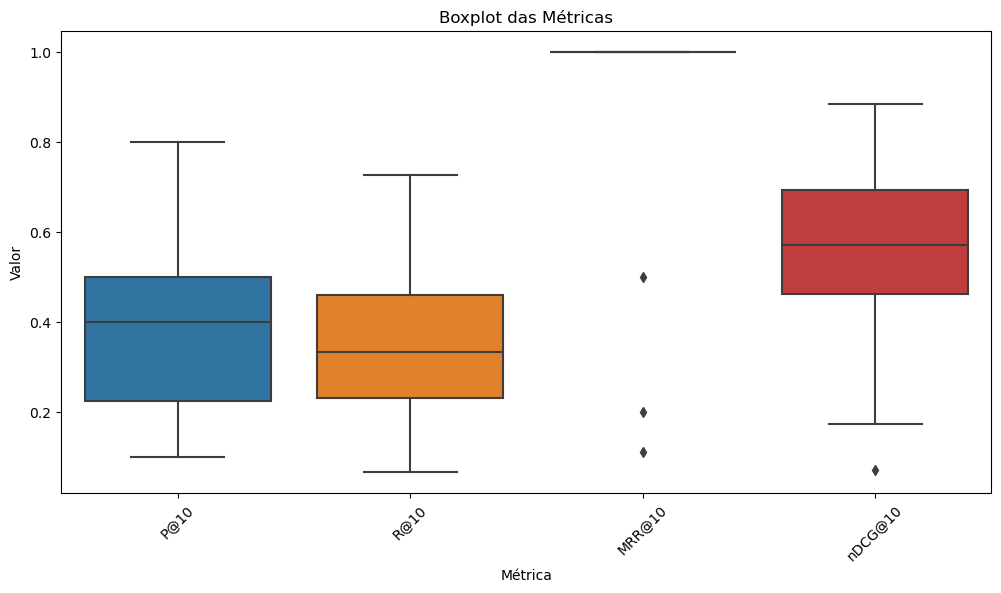

In [13]:
# Resultados para o terceiro grupo de queries:
display(df_metricas[100:150].describe())
histograma_metricas(df_metricas[100:150])
boxplot_metricas(df_metricas[100:150])

## Testes para comparar com os resultados com uma busca do BM25 implementado no LangChain

As células abaixo eram para estar num caderno só de testes. Mas como já tratei desse assunto aqui mesmo, vou gerar as mesmas métricas usando o BM25Retriever do LangChain aqui também. Apenas para verificar se os resultados estão compatíveis (não vai ser exatamente igual porque, embora as implementações sejam BM25-like, elas são um pouco diferentes).

https://api.python.langchain.com/en/latest/retrievers/langchain_community.retrievers.bm25.BM25Retriever.html#langchain_community.retrievers.bm25.BM25Retriever

https://python.langchain.com/v0.1/docs/integrations/retrievers/bm25/

In [14]:
from langchain_community.retrievers import BM25Retriever
from langchain_core.documents import Document

# Converte para documentos
docs_langchain = []
for i, row in docs.iterrows():
    docs_langchain.append(Document(page_content=row['ENUNCIADO'] + ' ' + row['EXCERTO'] + ' ' + row['DOC2QUERY'], metadata={"KEY": row['KEY']}))

In [15]:
%%time
# Demora cerca de 35 minutos para indexar
retriever = BM25Retriever.from_documents(docs_langchain, preprocess_func=tokenizador_pt_remove_html)

CPU times: total: 21min 25s
Wall time: 1h 1min 25s


In [16]:
# Altera para mostrar 50 resultados e testa pra ver se ele está aplicando a função de pré-processamento correta na query:
retriever.k = 50
retriever.preprocess_func('<a>técnica e preço')

['tecn', 'prec']

In [17]:
lang_col_resultado_query_key=[]
lang_col_resultado_doc_key=[]
lang_col_resultado_rank=[]

for i, row in queries.iterrows():
    query_key = row.KEY
    query_text = row.TEXT
    resultados = retriever.invoke(query_text)
  
    primeiros_50_docs = [resultado.metadata['KEY'] for resultado in resultados]
    queries_keys = [query_key] * len(primeiros_50_docs)
    ranking = list(range(1, len(primeiros_50_docs)+1))

    lang_col_resultado_query_key.extend(queries_keys)
    lang_col_resultado_doc_key.extend(primeiros_50_docs)
    lang_col_resultado_rank.extend(ranking)
    
df_resultados_langchain = pd.DataFrame({
    "QUERY_KEY": lang_col_resultado_query_key,
    "DOC_KEY": lang_col_resultado_doc_key,
    "RANK": lang_col_resultado_rank,
})

In [18]:
df_metricas_langchain = metricas(df_resultados_langchain, qrels, aproximacao_trec_eval=True)

O resultado está próximo ao implementado com a implementação própria. Difere ligeiramente, mas é devido à própria implementação do BM25.

O BM25Retriever do LangChain Community é um wrapper para o https://github.com/dorianbrown/rank_bm25/blob/master/rank_bm25.py . Nesse, a implementação do IDF é ligeiramente diferente: ele calcula log[(N - n + 0.5)/(n + 0.5)]. Na minha implementação, calculo log[(N - n + 0.5)/(n + 0.5) + bias], com bias = 1.

O bias = +1 que uso veio do modelo da Wikipedia e é uma forma de se evitar valores negativos para o IDF. Na implementação do BM25 Okapi, isso é resolvido de forma diferente. Após o cálculo, ele troca os idfs negativos por eps multiplicado pela média dos idfs dos termos do corpus.

A implementação padrão do BM25 Okapi usa k1=1.5, b=0.75, epsilon=0.25.

Rodar a implementação própria com k1=1.5, b=0.75 traz resultados muito próximos ao BM25Retriever.

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.388000,0.344000,0.249000,0.137600,0.156252,0.280529,0.408300,0.561993,0.630667,0.640667,0.645152,0.645152,0.397613,0.383054,0.437862,0.511890
std,14.57738,0.275266,0.184236,0.116273,0.050247,0.113311,0.161079,0.211382,0.237314,0.392682,0.378057,0.370665,0.370665,0.288272,0.229827,0.228665,0.219318
min,1.00000,0.000000,0.000000,0.050000,0.040000,0.000000,0.000000,0.066667,0.133333,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.034912,0.111933
25%,13.25000,0.200000,0.200000,0.150000,0.100000,0.071429,0.145604,0.230769,0.384615,0.270833,0.270833,0.270833,0.270833,0.169580,0.186411,0.217038,0.320265
50%,25.50000,0.400000,0.300000,0.250000,0.140000,0.142857,0.286364,0.408333,0.545455,0.750000,0.750000,0.750000,0.750000,0.386110,0.387672,0.462503,0.565479
75%,37.75000,0.600000,0.500000,0.300000,0.180000,0.223077,0.396154,0.525000,0.744318,1.000000,1.000000,1.000000,1.000000,0.614226,0.572608,0.633469,0.703948
max,50.00000,1.000000,0.700000,0.500000,0.220000,0.500000,0.600000,0.818182,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.846550,0.842570,0.842570


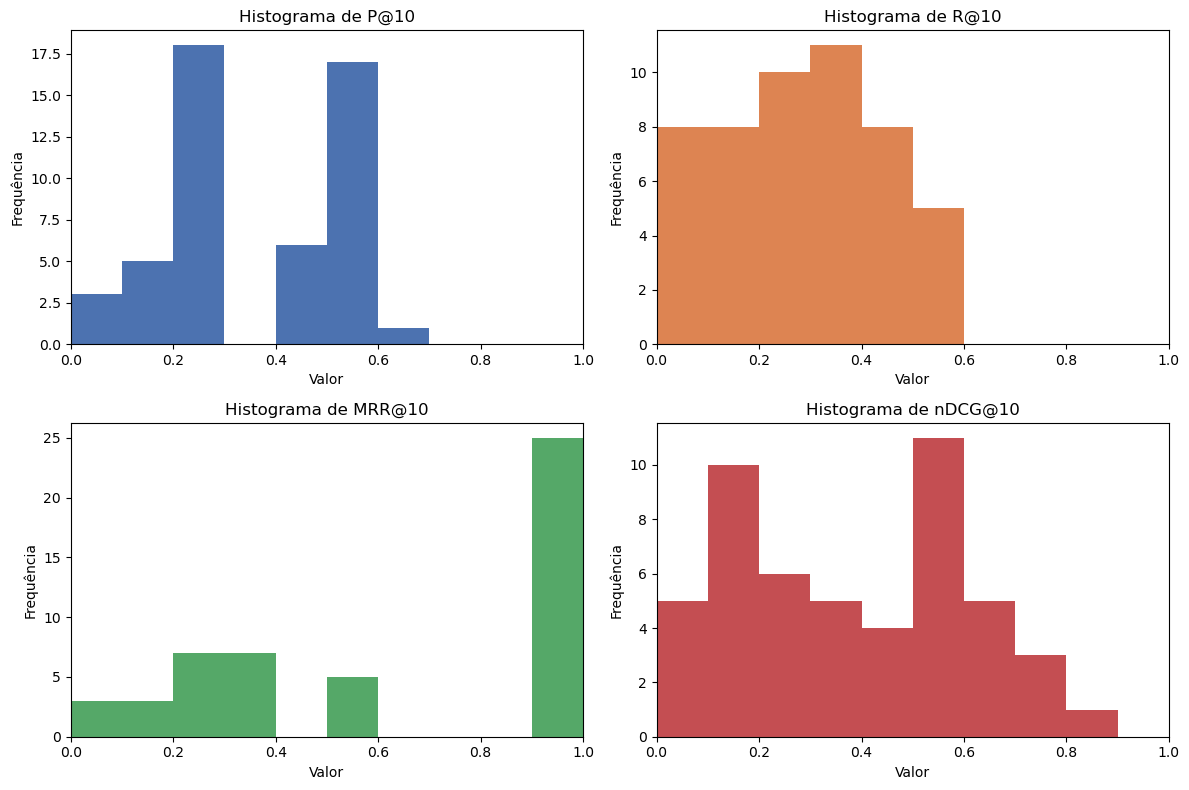

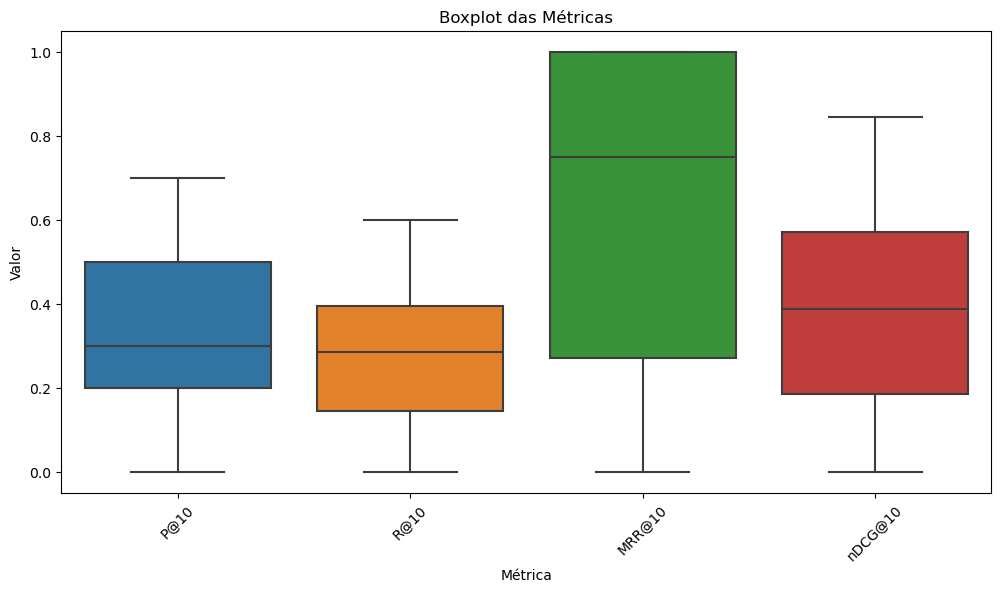

In [19]:
# Resultados para o primeiro grupo de queries:
display(df_metricas_langchain[0:50].describe())
histograma_metricas(df_metricas_langchain[0:50])
boxplot_metricas(df_metricas_langchain[0:50])